# GAN - Generative Adversarial Network

### Step 1 - Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import math # for generating real data (points on a circle in this case)

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
pandas: 1.3.4
matplotlib: 3.5.1
graphviz: 0.19.1
plotly: 5.4.0


### Step 2 - Prepare data

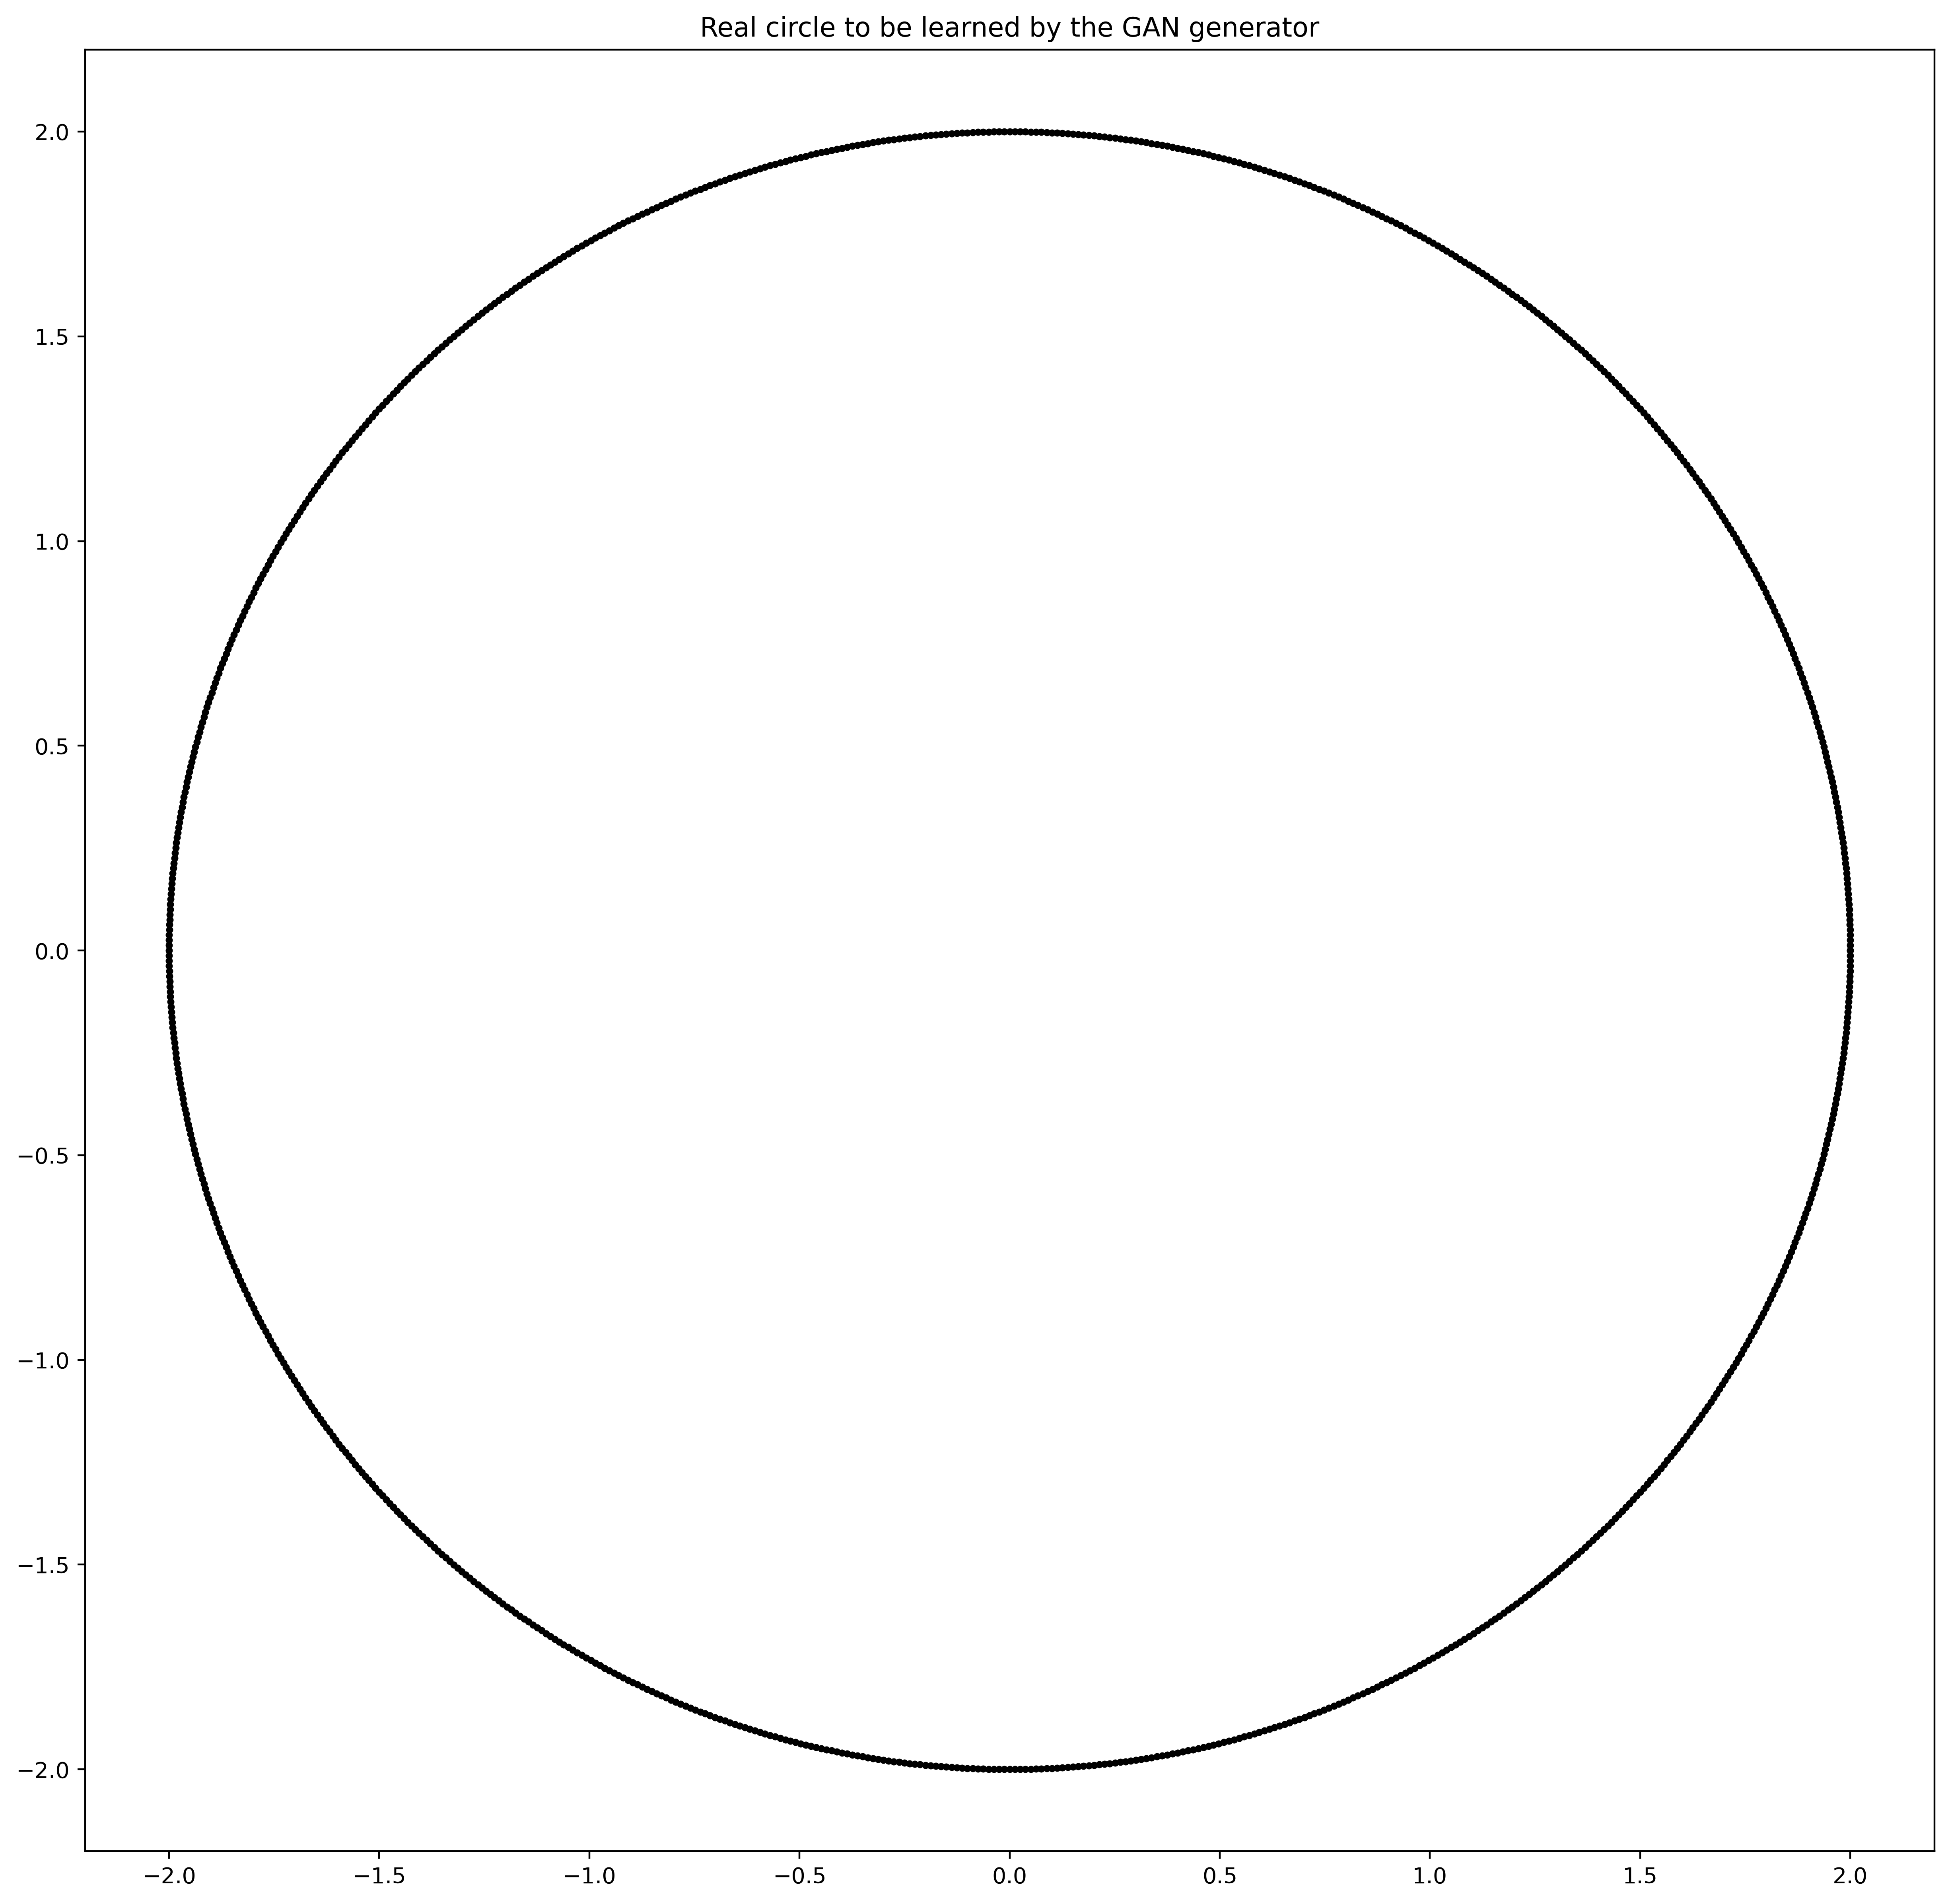

In [2]:
# A function to get coordinates of points on the circle's circumference
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in range(0,n+1)]

# Save coordinates of a set of real points making up a circle with radius=2
circle=np.array(PointsInCircum(r=2,n=1000))

# Draw a chart
plt.figure(figsize=(15,15), dpi=400)
plt.title(label='Real circle to be learned by the GAN generator', loc='center')
plt.scatter(circle[:,0], circle[:,1], s=5, color='black')
plt.show()

### Step 3 - Setup GAN

### Define Generator model

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 32)               128       
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-2 (D  (None, 16)               528       
 ense)                                                           
                                                                 
 Generator-Output-Layer (Den  (None, 2)                34        
 se)                                                             
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


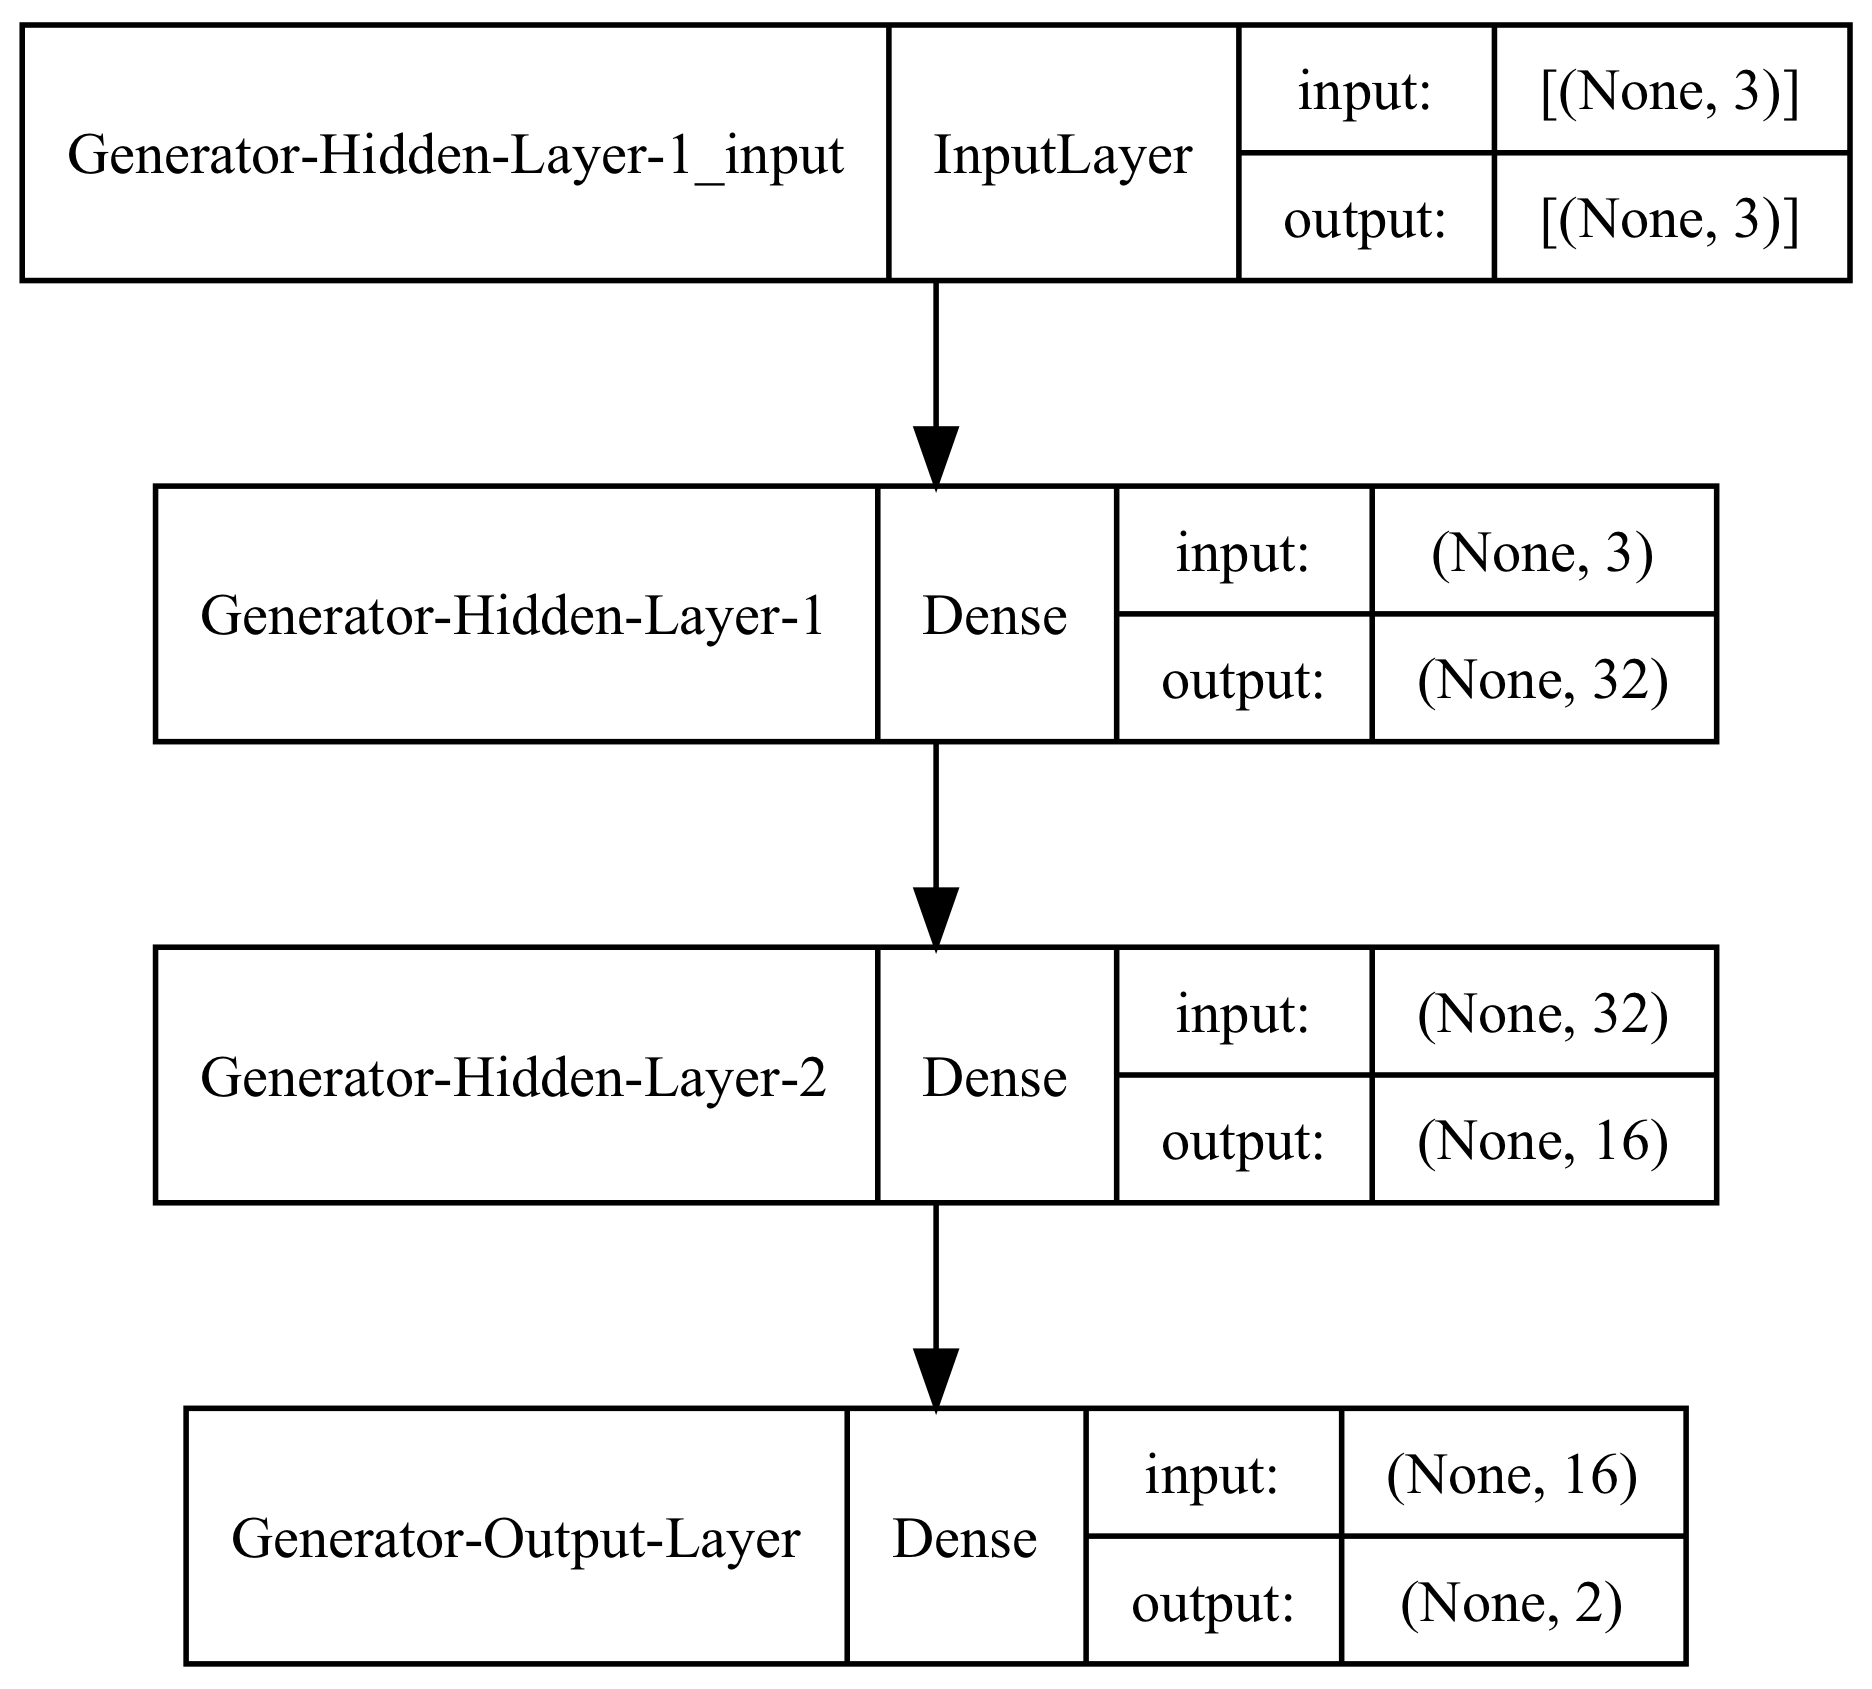

In [4]:
def generator(latent_dim, n_outputs=2):
    model = Sequential(name="Generator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim, name='Generator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Generator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(n_outputs, activation='linear', name='Generator-Output-Layer')) # Output Layer
    return model

# Instantiate
latent_dim=3
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

##### Define a Discriminator model

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32)               96        
 1 (Dense)                                                       
                                                                 
 Discriminator-Hidden-Layer-  (None, 16)               528       
 2 (Dense)                                                       
                                                                 
 Discriminator-Output-Layer   (None, 1)                17        
 (Dense)                                                         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


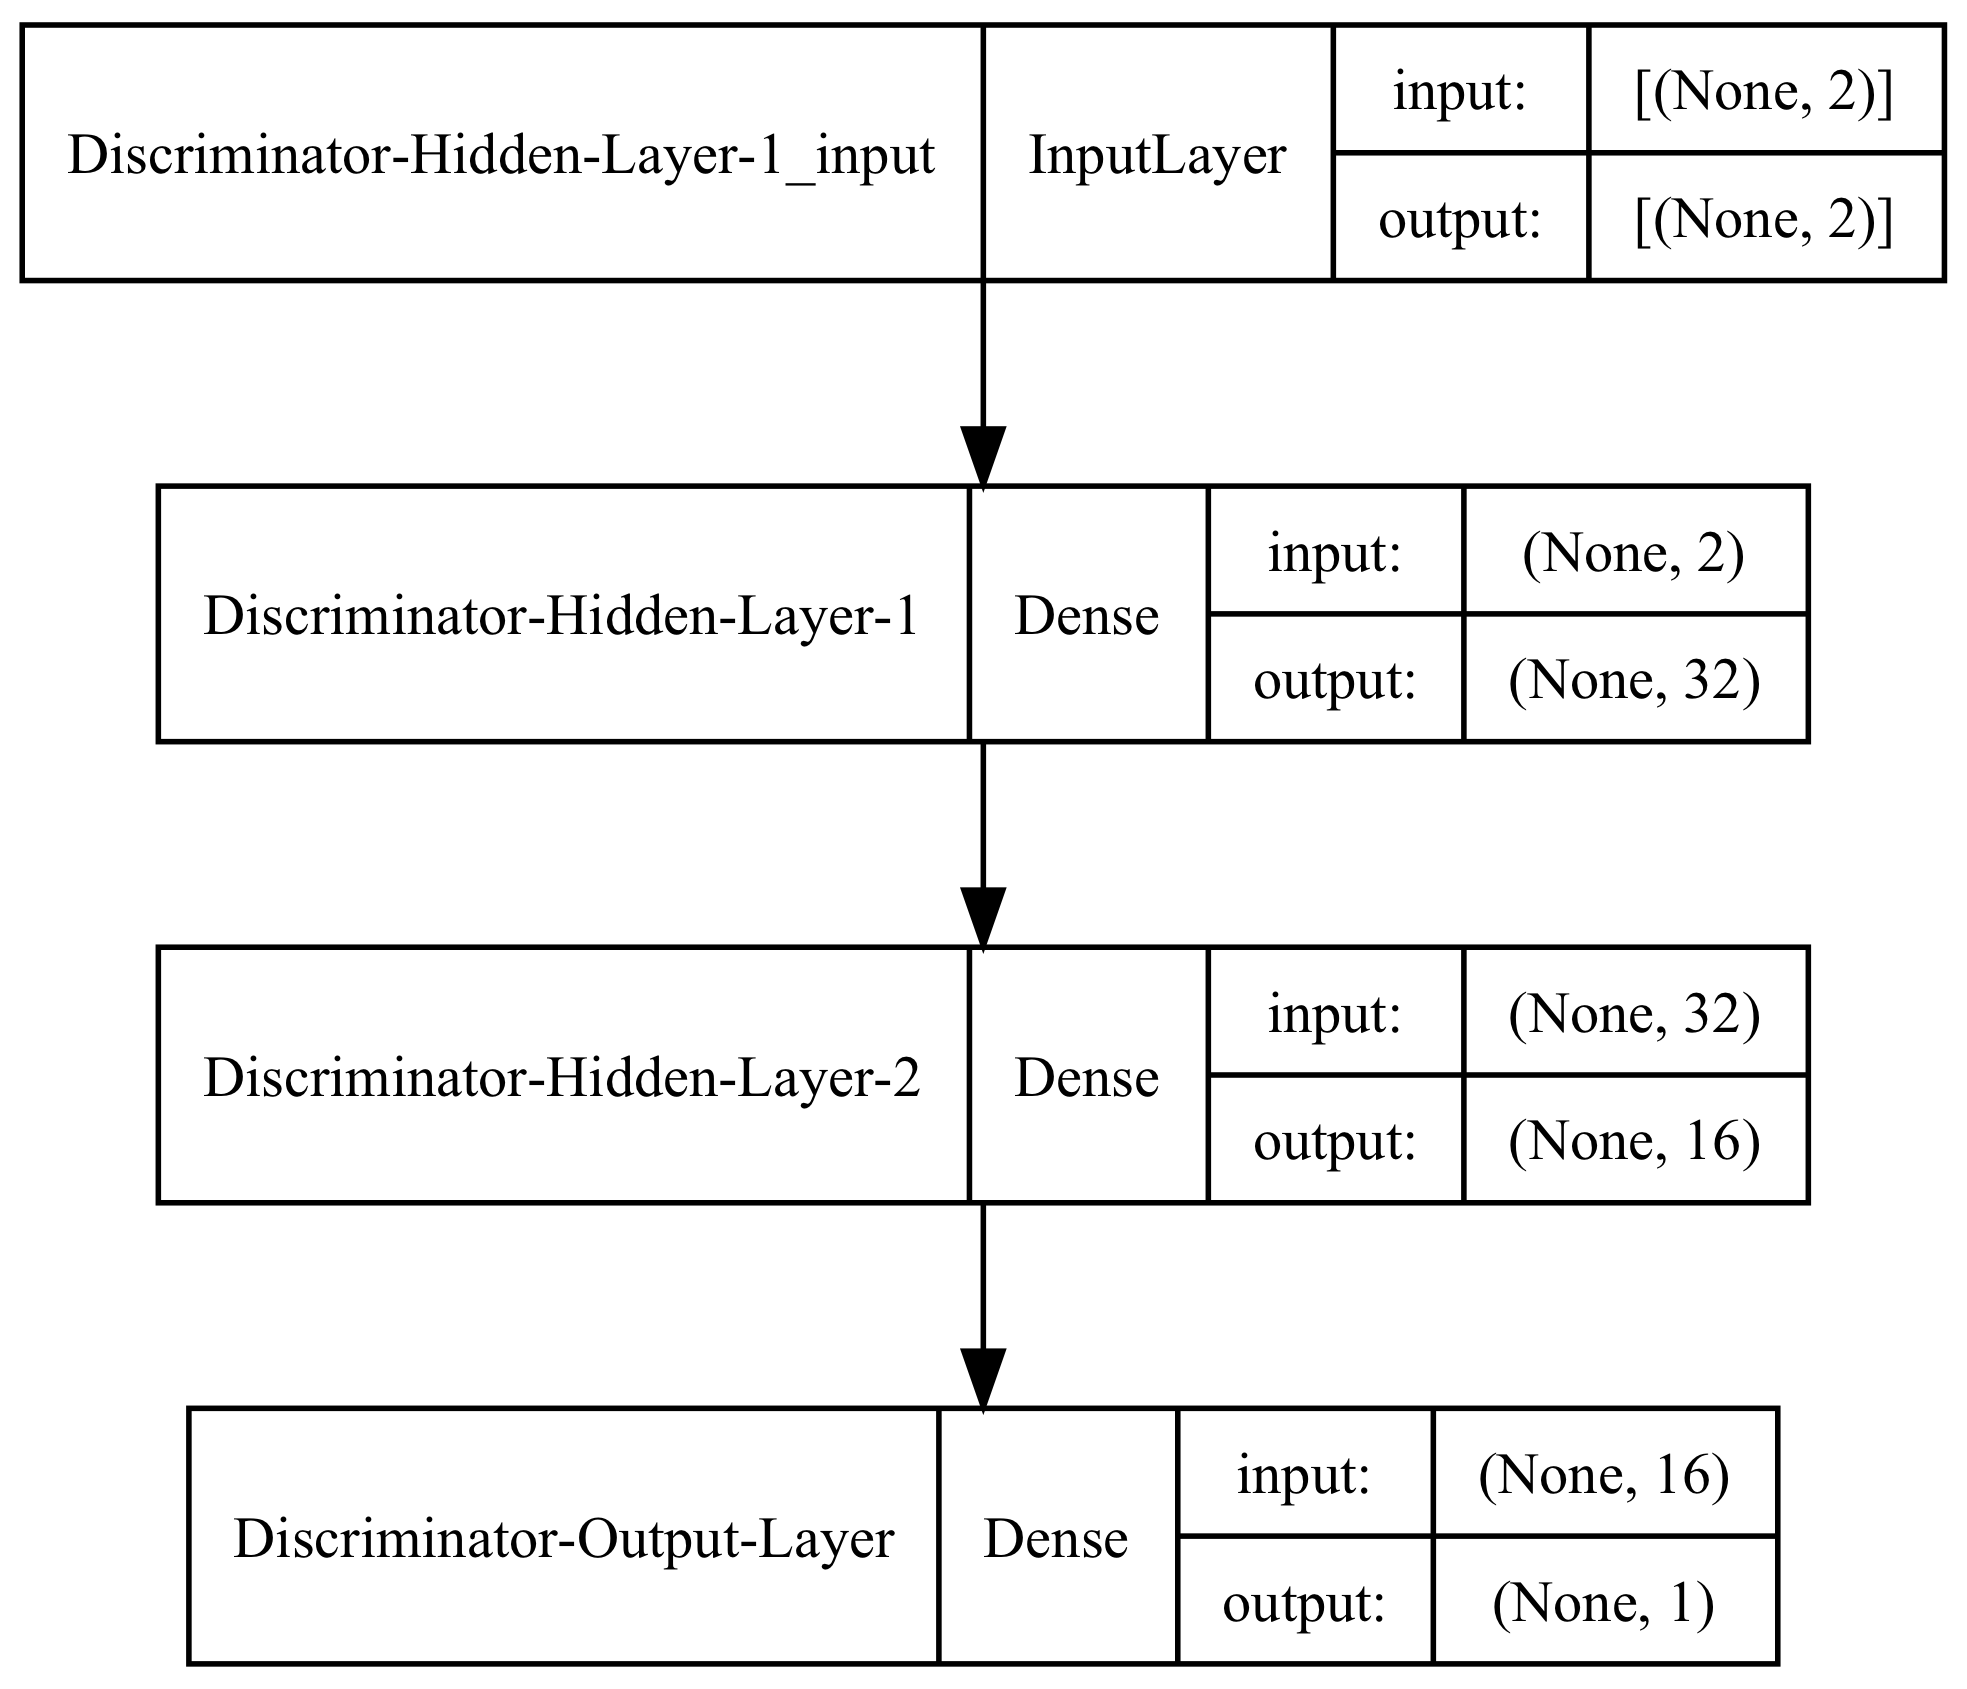

In [5]:
def discriminator(n_inputs=2):
    model = Sequential(name="Discriminator") # Model
    
    # Add Layers
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs, name='Discriminator-Hidden-Layer-1')) # Hidden Layer
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Discriminator-Hidden-Layer-2')) # Hidden Layer
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

##### Combine Generator and Discriminator models into trainable GAN 

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 2)                 690       
                                                                 
 Discriminator (Sequential)  (None, 1)                 641       
                                                                 
Total params: 1,331
Trainable params: 690
Non-trainable params: 641
_________________________________________________________________


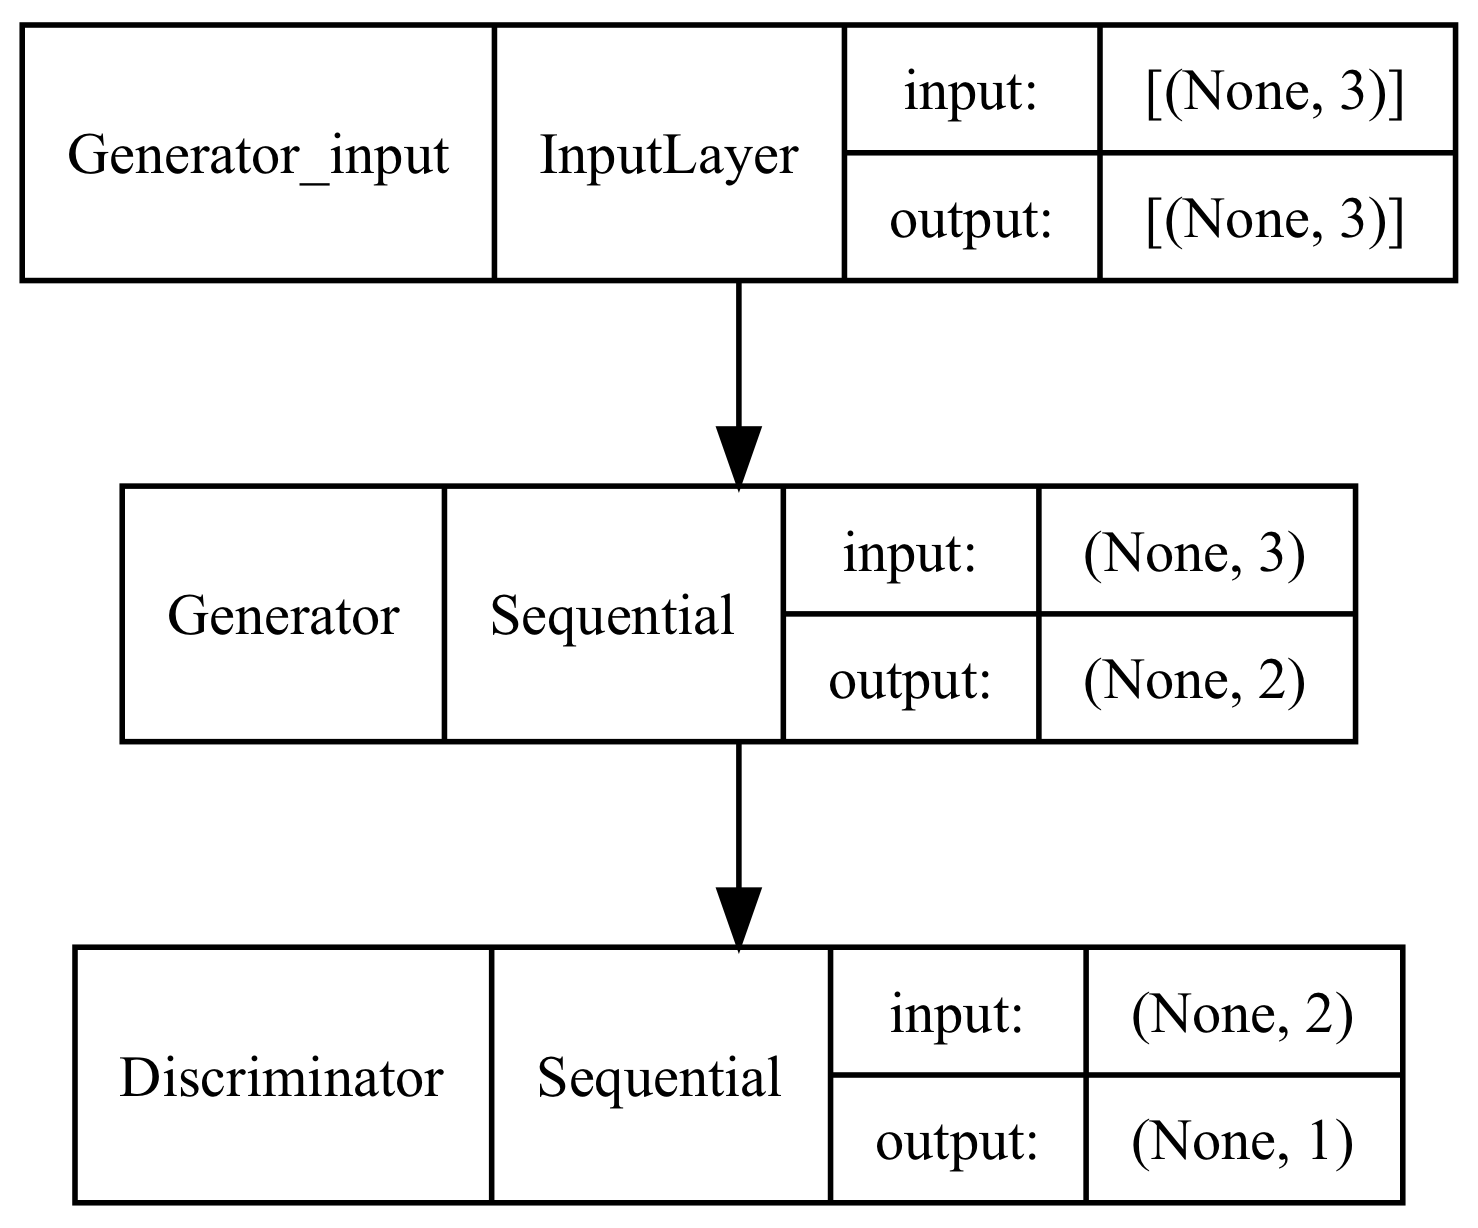

In [6]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="GAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)

### Step 4 - Setup functions to sample the latent space and real data, and to generate fake points using the generator model

##### Set up a function to sample random points form our circle 

In [7]:
def real_samples(n):
    
    # Samples of real data
    X = circle[np.random.choice(circle.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y

##### Generate points in the latent space, which we will use as inputs for the generator

In [8]:
def latent_points(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

##### The below function will use the generator to generate n fake examples together with class labels

In [9]:
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_points(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y

### Step 5 - Setup functions for model performance evaluation and training

##### Show Discriminator model accuracy and plot real vs. fake (generated) comparison

In [10]:
def performance_summary(epoch, generator, discriminator, latent_dim, n=100):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=1)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=1)
    
    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL points: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) points: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    plt.figure(figsize=(4,4), dpi=150)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, color='black')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=5, color='red')
    plt.show()

##### Define a function to train our GAN model (generator and discriminator)

In [11]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10001, n_batch=256, n_eval=1000):
    
    # Our batch to train the discriminator will consist of half real points and half fake (generated) points
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
    
    # Generator training
        # Get points from the latent space to be used as inputs for the generator
        x_gan = latent_points(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            performance_summary(i, g_model, d_model, latent_dim)

### Step 6 - Train the model and plot the results

##### Use the above train function to train our GAN model

4/4 [==============================] - 0s 1ms/step - loss: 0.2371 - accuracy: 1.0000
Epoch number:  0
Discriminator Accuracy on REAL points:  0.0
Discriminator Accuracy on FAKE (generated) points:  1.0


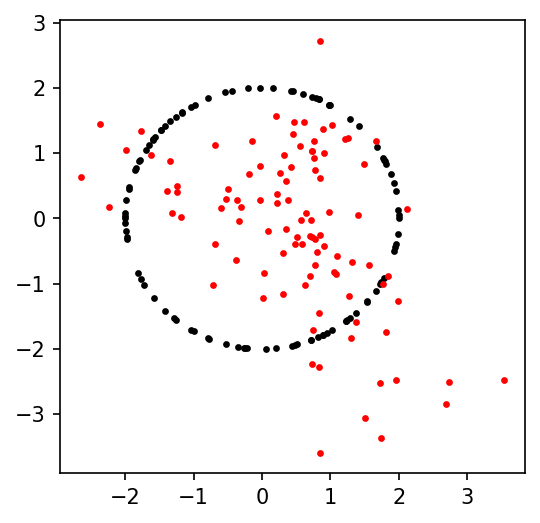

4/4 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5100
Epoch number:  1000
Discriminator Accuracy on REAL points:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) points:  0.5099999904632568


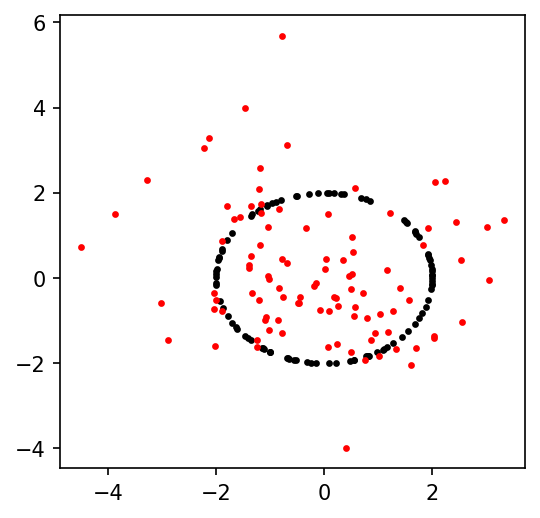

4/4 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4800
Epoch number:  2000
Discriminator Accuracy on REAL points:  0.699999988079071
Discriminator Accuracy on FAKE (generated) points:  0.47999998927116394


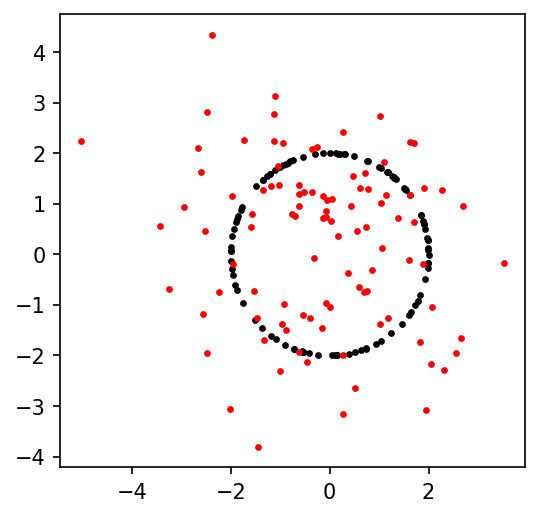

4/4 [==============================] - 0s 1ms/step - loss: 0.6681 - accuracy: 0.6000
Epoch number:  3000
Discriminator Accuracy on REAL points:  0.7099999785423279
Discriminator Accuracy on FAKE (generated) points:  0.6000000238418579


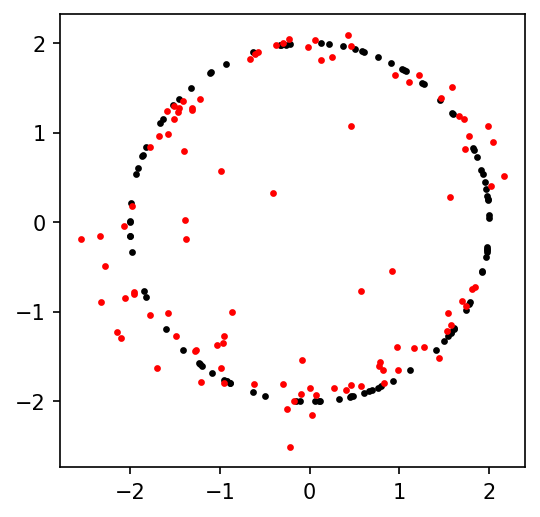

4/4 [==============================] - 0s 1ms/step - loss: 0.7271 - accuracy: 0.2900
Epoch number:  4000
Discriminator Accuracy on REAL points:  0.949999988079071
Discriminator Accuracy on FAKE (generated) points:  0.28999999165534973


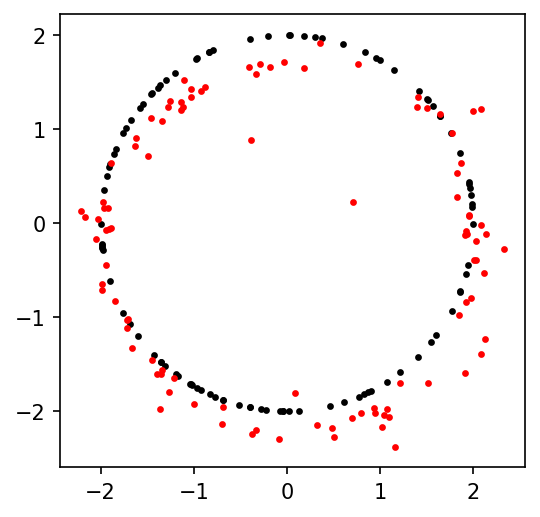

4/4 [==============================] - 0s 1ms/step - loss: 0.6850 - accuracy: 0.4700
Epoch number:  5000
Discriminator Accuracy on REAL points:  1.0
Discriminator Accuracy on FAKE (generated) points:  0.4699999988079071


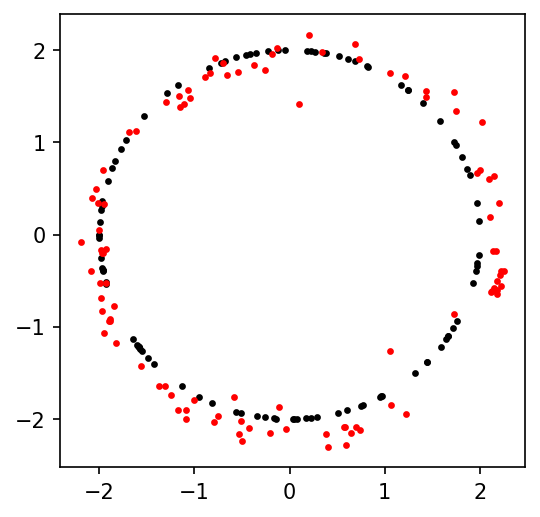

4/4 [==============================] - 0s 2ms/step - loss: 0.6763 - accuracy: 0.6100
Epoch number:  6000
Discriminator Accuracy on REAL points:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) points:  0.6100000143051147


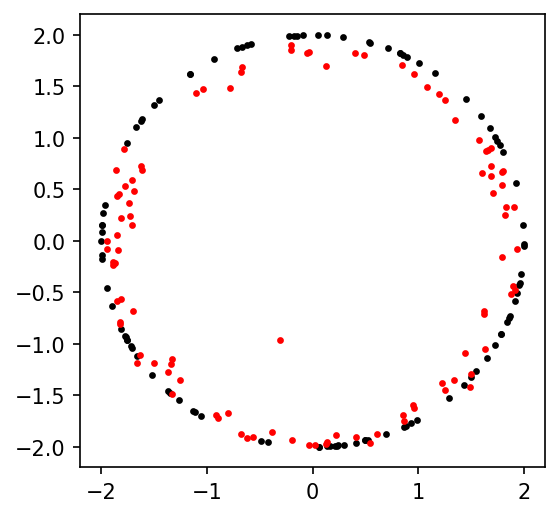

4/4 [==============================] - 0s 1ms/step - loss: 0.6687 - accuracy: 0.5500
Epoch number:  7000
Discriminator Accuracy on REAL points:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) points:  0.550000011920929


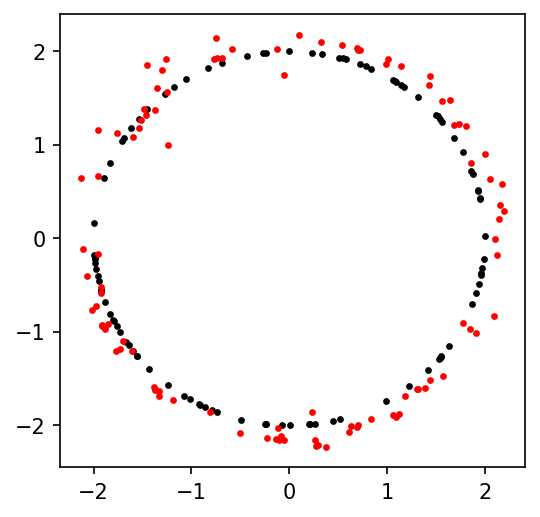

4/4 [==============================] - 0s 1ms/step - loss: 0.6430 - accuracy: 0.7200
Epoch number:  8000
Discriminator Accuracy on REAL points:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) points:  0.7200000286102295


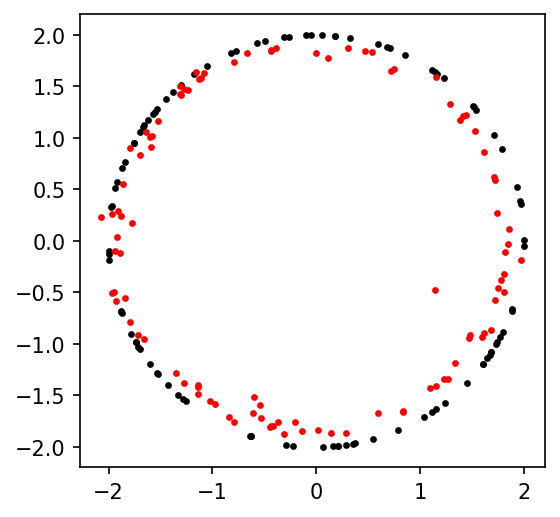

4/4 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.7000
Epoch number:  9000
Discriminator Accuracy on REAL points:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) points:  0.699999988079071


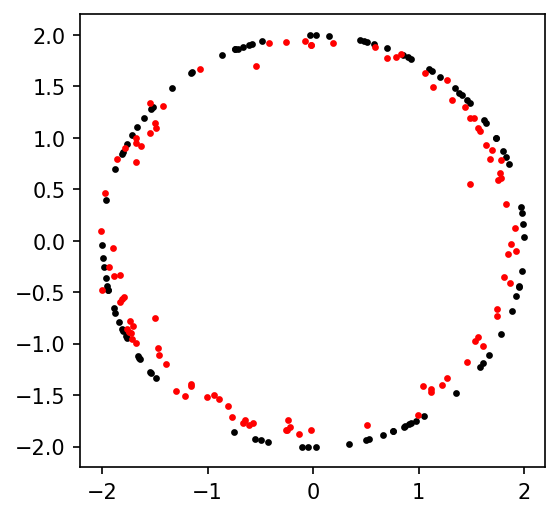

4/4 [==============================] - 0s 5ms/step - loss: 0.6436 - accuracy: 0.7500
Epoch number:  10000
Discriminator Accuracy on REAL points:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) points:  0.75


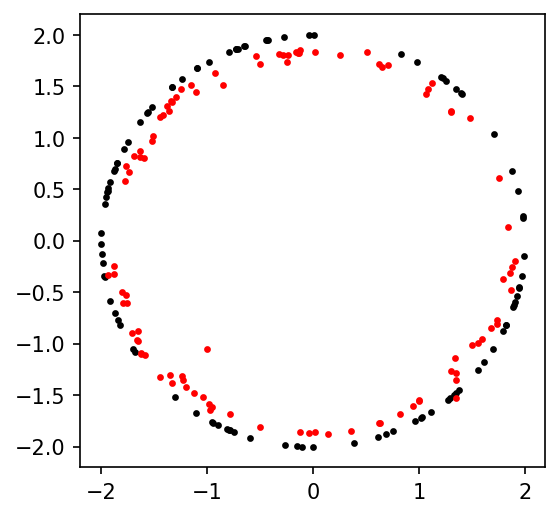

In [12]:
# Train GAN model
train(gen_model, dis_model, gan_model, latent_dim)

##### Check distribution stats for fake and real data points

In [13]:
# Generate 1000 fake samples
x_fake, y_fake = fake_samples(gen_model, latent_dim, 1000)
df_fake = pd.DataFrame(x_fake, columns=['x dimension', 'y dimension'])

# Sample 1000 real points
x_real, y_real = real_samples(1000)
df_real = pd.DataFrame(x_real, columns=['x dimension', 'y dimension'])

# Show summary statistics
print("Distribution statistics of fake (generated) points")
print(df_fake.describe())
print("----------------------------------------")
print("Distribution statisticss of real points")
print(df_real.describe())

Distribution statistics of fake (generated) points
       x dimension  y dimension
count  1000.000000  1000.000000
mean     -0.090935     0.041814
std       1.333691     1.294546
min      -2.038448    -1.944356
25%      -1.408432    -1.181883
50%      -0.239530    -0.018117
75%       1.286680     1.327206
max       1.963275     1.876877
----------------------------------------
Distribution statisticss of real points
       x dimension  y dimension
count  1000.000000  1000.000000
mean     -0.015013    -0.007014
std       1.412151     1.417589
min      -2.000000    -1.999961
25%      -1.423071    -1.475026
50%      -0.031414     0.075380
75%       1.423071     1.350666
max       2.000000     2.000000


---

### Appendix - What does the latent space look like?

In [14]:
latent_test = np.random.randn(latent_dim * 20000)
# Reshape into a batch of inputs for the network
latent_test = latent_test.reshape(20000, latent_dim)
#latent_test

# Create a 3D scatter plot
fig = px.scatter_3d(x=latent_test[:,0], y=latent_test[:,1], z=latent_test[:,2],
                 opacity=0.8, color_discrete_sequence=['black'], height=900, width=1000)

# Set figure title and colors
fig.update_layout(#title_text="Scatter 3D Plot with FF Neural Network Prediction Surface",
                  paper_bgcolor = 'white',
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                    center=dict(x=0, y=0, z=-0.1),
                                    eye=dict(x=0.75, y=-1.75, z=1)),
                                    margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(title='x1',
                                          backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0'),
                               yaxis=dict(title='x2',
                                          backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0'
                                          ),
                               zaxis=dict(title='x3',
                                          backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0', 
                                          )))

# Update marker size
fig.update_traces(marker=dict(size=1))

##### Pick a few vectors from the latent space and predict using out generator model

In [15]:
print("Result for [0,0,0] vector]: ", gen_model.predict([[0,0,0]]))
print("Result for [1,0,0] vector]: ", gen_model.predict([[1,0,0]]))
print("Result for [1,1,0] vector]: ", gen_model.predict([[1,1,0]]))
print("Result for [1,1,1] vector]: ", gen_model.predict([[1,1,1]]))

Result for [0,0,0] vector]:  [[1.6862988 0.8395865]]
Result for [1,0,0] vector]:  [[1.7817135 0.5669633]]
Result for [1,1,0] vector]:  [[ 1.6565058  -0.88929474]]
Result for [1,1,1] vector]:  [[1.8680761  0.21529415]]


# End of Program